<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from fastai.io import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from pandas_summary import DataFrameSummary
from IPython.display import display
from sklearn import metrics
import feather
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
import warnings
import gc
from sklearn.linear_model import Ridge

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [4]:
train_df2 = feather.read_dataframe('train_df_beta')

In [5]:
train_df2.shape

(201917, 253)

In [6]:
base_cols = ['feature_1','feature_2','feature_3','transactions_count','subsector_id_nunique','merchant_id_nunique','merchant_category_id_nunique','purchase_Month_mean','purchase_Month_min','purchase_Month_max','purchase_Week_nunique','purchase_Week_mean','purchase_Week_min','purchase_Week_max','purchase_Dayofweek_mean','purchase_Dayofweek_min','purchase_Dayofweek_max','purchase_Day_nunique','purchase_Day_mean','purchase_Day_min','purchase_Day_max','purchase_Hour_nunique','purchase_Hour_mean','purchase_Hour_min','purchase_Hour_max','purchase_amount_sum','purchase_amount_max','purchase_amount_min','purchase_amount_mean','purchase_amount_var','purchase_amount_skew','installments_sum','installments_max','installments_mean','installments_var','installments_skew','month_lag_max','month_lag_min','month_lag_mean','month_lag_var','month_lag_skew','month_diff_mean','month_diff_var','month_diff_skew','purchased_on_weekend_mean','category_1_mean','category_2_mean','category_3_mean','card_id_count','price_mean','price_max','price_min','price_var','Christmas_Day_2017_mean','Children_day_2017_mean','Black_Friday_2017_mean','Mothers_Day_2018_mean','duration_mean','duration_min','duration_max','duration_var','duration_skew','amount_month_ratio_mean','amount_month_ratio_min','amount_month_ratio_max','amount_month_ratio_var','amount_month_ratio_skew','category_2_mean_mean','category_3_mean_mean','purchase_date_diff','purchase_date_average','purchase_date_uptonow','purchase_date_uptomin','transactions_count_old','subsector_id_nunique_old','merchant_id_nunique_old','merchant_category_id_nunique_old','purchase_Month_nunique','purchase_Month_mean_old','purchase_Month_min_old','purchase_Month_max_old','purchase_Week_nunique_old','purchase_Week_mean_old','purchase_Week_min_old','purchase_Week_max_old','purchase_Dayofweek_mean_old','purchase_Day_nunique_old','purchase_Day_mean_old','purchase_Day_min_old','purchase_Hour_nunique_old','purchase_Hour_mean_old','purchase_Hour_min_old','purchase_Hour_max_old','purchase_amount_sum_old','purchase_amount_max_old','purchase_amount_min_old','purchase_amount_mean_old','purchase_amount_var_old','purchase_amount_skew_old','installments_sum_old','installments_max_old','installments_mean_old','installments_var_old','installments_skew_old','month_lag_max_old','month_lag_min_old','month_lag_mean_old','month_lag_var_old','month_lag_skew_old','month_diff_max','month_diff_min','month_diff_mean_old','month_diff_var_old','month_diff_skew_old','authorized_flag_mean','purchased_on_weekend_mean_old','category_1_mean_old','category_2_mean_old','category_3_mean_old','card_id_count_old','price_sum','price_mean_old','price_max_old','price_min_old','price_var_old','Christmas_Day_2017_mean_old','Mothers_Day_2017_mean','fathers_day_2017_mean','Children_day_2017_mean_old','Valentine_Day_2017_mean','Black_Friday_2017_mean_old','Mothers_Day_2018_mean_old','duration_mean_old','duration_min_old','duration_max_old','duration_var_old','duration_skew_old','amount_month_ratio_mean_old','amount_month_ratio_min_old','amount_month_ratio_max_old','amount_month_ratio_var_old','amount_month_ratio_skew_old','category_2_mean_mean_old','category_3_mean_mean_old','purchase_date_diff_old','purchase_date_average_old','purchase_date_uptonow_old','purchase_date_uptomin_old','quarter','elapsed_time','days_feature1','days_feature2','days_feature3','days_feature1_ratio','days_feature2_ratio','days_feature3_ratio','feature_sum','feature_mean','feature_max','feature_min','feature_var','card_id_total','card_id_count_total','card_id_count_ratio','purchase_amount_total','purchase_amount_total_mean','purchase_amount_total_max','purchase_amount_total_min','purchase_amount_sum_ratio','hist_first_buy','new_first_buy','hist_last_buy','new_last_buy','month_diff_ratio','installments_total','installments_ratio','price_total','CLV','CLV_old','CLV_ratio']

In [7]:
for df in [train_df2]:
    for f in ['purchase_date_max','purchase_date_min','purchase_date_max_old',\
                     'purchase_date_min_old']:
        df[f] = df[f].astype(np.int64) * 1e-9
        
cols_excluded = ['purchase_date_max', 'purchase_date_max_old', 'card_id', 'first_active_month',
                 'target','outliers','card_id_size', 'card_id_size_old', 
                 'purchase_date_min', 'purchase_date_min_old','first_active_monthYear',
                 'first_active_monthMonth',
                 'first_active_monthWeek',
                 'first_active_monthDay',
                 'first_active_monthDayofweek',
                 'first_active_monthDayofyear',
                 'first_active_monthIs_month_end',
                 'first_active_monthIs_month_start',
                 'first_active_monthIs_quarter_end',
                 'first_active_monthIs_quarter_start',
                 'first_active_monthIs_year_end',
                 'first_active_monthIs_year_start']

In [8]:
df_train_columns = [c for c in train_df2.columns.values if c not in cols_excluded]

In [9]:
x, x_t, y, y_t = train_test_split(train_df2, train_df2['target'], 
                                 stratify=train_df2['outliers'], test_size=.1, random_state=1)

In [10]:
x.shape, x_t.shape

((181725, 253), (20192, 253))

In [11]:
x, x_t, y, y_t = train_test_split(x, y, 
                                 stratify=x['outliers'], test_size=.2, random_state=1)

In [12]:
x.shape, x_t.shape

((145380, 253), (36345, 253))

In [13]:
(x['outliers']==1).sum(), (x_t['outliers']==1).sum()

(1589, 397)

In [14]:
y.shape, y_t.shape

((145380,), (36345,))

In [15]:
df_train_columns = base_cols

In [16]:
len(df_train_columns)

180

In [17]:
x = x[df_train_columns]
x_t = x_t[df_train_columns]

In [18]:
lgb_param = {
        'task': 'train',
        'boosting': 'goss',
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.01,
        'subsample': 0.9855232997390695,
        'max_depth': 7,
        'top_rate': 0.9064148448434349,
        'num_leaves': 123,
        'min_child_weight': 41.9612869171337,
        'other_rate': 0.0721768246018207,
        'reg_alpha': 9.677537745007898,
        'colsample_bytree': 0.5665320670155495,
        'min_split_gain': 9.820197773625843,
        'reg_lambda': 8.2532317400459,
        'min_data_in_leaf': 21,
        'verbose': -1,
        'seed':int(2**5),
        'bagging_seed':int(2**5),
        'drop_seed':int(2**5)
        }
trn_data = lgb.Dataset(x[base_cols], label=y)
val_data = lgb.Dataset(x_t[base_cols], label=y_t)

In [19]:
num_round = 10000
%time clf = lgb.train(lgb_param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=0, early_stopping_rounds = 200)
oof = clf.predict(x_t[base_cols], num_iteration=clf.best_iteration)
np.sqrt(mean_squared_error(oof, y_t))

CPU times: user 1min 41s, sys: 333 ms, total: 1min 41s
Wall time: 17.2 s


3.6524335955342595

In [114]:
base_cols2 = ['feature_1', 'feature_2', 'feature_3']

In [168]:
cols_to_add = [c for c in df_train_columns if c not in base_cols2]

In [169]:
len(cols_to_add)

240

In [119]:
base_score2 = 3.847374431825333

In [72]:
base_score = 3.691041093650063

In [189]:
selected_cols = []

In [190]:
fe_deltas_df = pd.DataFrame()

In [191]:
final_cols = base_cols2

In [192]:
fe_d = {}

In [202]:
for c in cols_to_add:
    lgb_cols = final_cols + [c]
    print(len(lgb_cols), 'lg_cols')
    trn_data = lgb.Dataset(x[lgb_cols], label=y)
    val_data = lgb.Dataset(x_t[lgb_cols], label=y_t)
    clf = lgb.train(lgb_param, trn_data, num_round, 
                    valid_sets = [trn_data, val_data], verbose_eval=0, early_stopping_rounds = 200)
    oof = clf.predict(x_t[lgb_cols], num_iteration=clf.best_iteration)
    score = np.sqrt(mean_squared_error(y_t, oof))
    delta = base_score - score
    fe_d[c] = delta
    if delta < 0:
        selected_cols.append(c)
        final_cols = final_cols + [c]

4 lg_cols
5 lg_cols
6 lg_cols
7 lg_cols
8 lg_cols
9 lg_cols
10 lg_cols
11 lg_cols
12 lg_cols
13 lg_cols
14 lg_cols
15 lg_cols
16 lg_cols
17 lg_cols
18 lg_cols
19 lg_cols
20 lg_cols
21 lg_cols
22 lg_cols
23 lg_cols
24 lg_cols
25 lg_cols
26 lg_cols
27 lg_cols
28 lg_cols
29 lg_cols
30 lg_cols
31 lg_cols
32 lg_cols
33 lg_cols
34 lg_cols
35 lg_cols
36 lg_cols
37 lg_cols
38 lg_cols
39 lg_cols
40 lg_cols
41 lg_cols
42 lg_cols
43 lg_cols
44 lg_cols
45 lg_cols
46 lg_cols
47 lg_cols
48 lg_cols
49 lg_cols
50 lg_cols
51 lg_cols
52 lg_cols
53 lg_cols
54 lg_cols
55 lg_cols
56 lg_cols
57 lg_cols
58 lg_cols
59 lg_cols
60 lg_cols
61 lg_cols
62 lg_cols


KeyboardInterrupt: 

In [194]:
gc.collect()

578

In [195]:
len(selected_cols)

0

In [196]:
fe_deltas_df = pd.DataFrame.from_dict(fe_d, orient='index')

In [197]:
fe_deltas_df

,0
transactions_count,-0.150052
subsector_id_nunique,-0.148867
merchant_id_nunique,-0.150136
merchant_category_id_nunique,-0.149662
purchase_Month_mean,-0.117247
purchase_Month_min,-0.118750
purchase_Month_max,-0.116200
purchase_Week_nunique,-0.149430
purchase_Week_mean,-0.106378
purchase_Week_min,-0.114731


In [199]:
fe_df = fe_deltas_df.reset_index()
fe_df.columns = ['feature', 'delta']

In [200]:
fe_df.sort_values('delta', ascending=True)

,feature,delta
105,purchase_amount_median_old,-0.157000
196,category_2_5.0_purchase_amount_sum,-0.157000
193,category_2_2.0_purchase_amount_sum,-0.157000
185,category_1_0_purchase_amount_sum,-0.157000
115,month_lag_max_old,-0.157000
182,purchase_amount_mean_max,-0.157000
174,purchase_amount_sum_max,-0.157000
204,authorized_flag_1_purchase_amount_mean,-0.157000
95,purchase_Day_mean_old,-0.157000
98,purchase_Hour_mean_old,-0.157000


In [129]:
from sklearn.metrics.scorer import make_scorer

In [234]:
def rmse(actual, predict):
    return mean_squared_error(actual, predict)

rmse_score = make_scorer(rmse, greater_is_better = False)

In [20]:
clf = Ridge(alpha=1.0)

In [21]:
from sklearn.pipeline import make_pipeline

In [32]:
sfs = SFS(clf, 
          k_features=160, 
          forward=True, 
          floating=False, 
          scoring='r2',
          cv=5,
          n_jobs=-1)
pipe = make_pipeline(sfs)

In [47]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [23]:
len(df_train_columns)

180

In [24]:
x.fillna(0, inplace=True)
x.replace(-np.inf, 0, inplace=True)
x.replace(np.inf, 0, inplace=True)

In [33]:
gc.collect()

5806

In [34]:
%time pipe.fit(x[df_train_columns].values, y)

/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/chandrasekhar/anaco

CPU times: user 3min 55s, sys: 27.6 s, total: 4min 23s
Wall time: 53min 40s


Pipeline(memory=None,
     steps=[('sequentialfeatureselector', SequentialFeatureSelector(clone_estimator=True, cv=5,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
             floating=False, forward=True, k_features=160, n_jobs=-1,
             pre_dispatch='2*n_jobs', scoring='r2', verbose=0))])

In [35]:
sfs.k_score_ #160 72% dataset

0.046826811091055645

In [27]:
sfs.k_score_ #40 72% dataset

0.04270958032826948

In [64]:
sfs.k_score_ #40 10% dataset

0.045418292964324404

In [51]:
sfs.k_score_ #160

0.040013368847060214

In [30]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [36]:
print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_idx_))

best combination (ACC: 0.047): (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 58, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 138, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 179)



In [98]:
print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_idx_))
print('all subsets:\n', sfs.subsets_)

best combination (ACC: -14.237): (0, 1, 2, 3, 4, 5, 6, 10, 14, 15, 17, 18, 19, 21, 22, 25, 26, 27, 28, 30, 31, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 48, 49, 53, 56, 62, 63, 64, 65, 66, 67, 70, 71, 73, 77, 79, 80, 81, 82, 83, 86, 87, 89, 91, 96, 100, 101, 102, 103, 104, 106, 107, 108, 111, 112, 113, 116, 118, 119, 122, 124, 128, 129, 130, 131, 134, 135, 136, 138, 139, 141, 143, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 161, 163, 165, 168, 169)

all subsets:
 {1: {'feature_idx': (108,), 'cv_scores': array([-13.0142 , -16.20725, -14.21346, -15.21542]), 'avg_score': -14.662580626967827, 'feature_names': ('108',)}, 2: {'feature_idx': (77, 108), 'cv_scores': array([-12.91242, -16.08779, -14.02797, -15.15898]), 'avg_score': -14.54678860569546, 'feature_names': ('77', '108')}, 3: {'feature_idx': (26, 77, 108), 'cv_scores': array([-12.88092, -16.03325, -13.96852, -15.09211]), 'avg_score': -14.493701100309321, 'feature_names': ('26', '77', '108')}, 4: {'feature_idx': (26, 

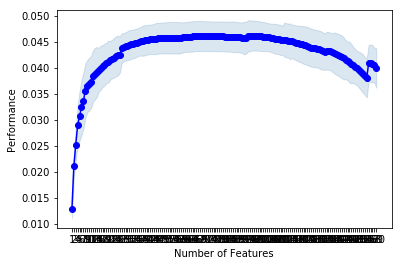

In [54]:
plot_sfs(sfs.get_metric_dict(), kind='std_err');

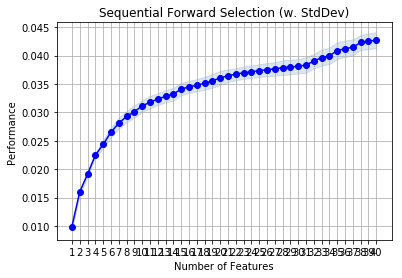

In [31]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

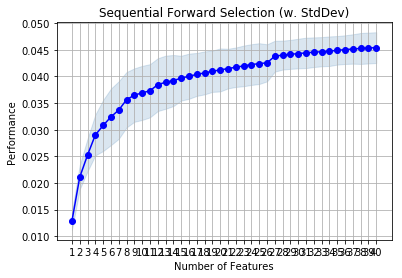

In [67]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [43]:
np.arange(160)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,
        20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159])

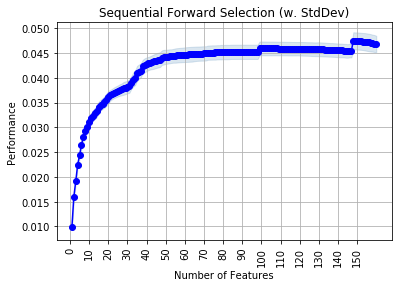

In [47]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection (w. StdDev)')
pos = np.arange(160)
ticks = plt.xticks(pos[::10], pos[::10], rotation=90)
plt.grid()
plt.show() #full 72% dataset


In [181]:
feats_se_100 = [0, 1, 2, 3, 4, 5, 6, 9, 10, 13, 14, 15, 17, 19, 21, 23, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 52, 56, 59, 63, 66, 67, 68, 70, 71, 73, 75, 76, 80, 83, 84, 85, 89, 91, 92, 94, 95, 99, 100, 103, 104, 107, 109, 110, 111, 114, 115, 119, 120, 123, 127, 130, 131, 133, 135, 137, 138, 143, 145, 146, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 168, 172, 173, 174, 175, 176, 177, 179]

In [193]:
cols_fe_100 = x.columns[feats_se_100]

In [186]:
feats_se_80 = [0, 1, 2, 3, 4, 6, 9, 13, 14, 15, 19, 21, 23, 26, 27, 28, 31, 32, 34, 35, 36, 37, 40, 41, 43, 44, 45, 46, 47, 48, 50, 52, 56, 59, 63, 66, 67, 68, 70, 71, 75, 76, 80, 83, 89, 92, 94, 99, 100, 104, 107, 109, 110, 111, 114, 115, 120, 123, 127, 130, 131, 135, 137, 138, 143, 146, 153, 154, 155, 156, 157, 159, 160, 161, 162, 168, 173, 174, 177, 179]

In [187]:
x.columns[feats_se_80]

Index(['feature_1', 'feature_2', 'feature_3', 'transactions_count',
       'subsector_id_nunique', 'merchant_category_id_nunique',
       'purchase_Month_max', 'purchase_Week_max', 'purchase_Dayofweek_mean',
       'purchase_Dayofweek_min', 'purchase_Day_min', 'purchase_Hour_nunique',
       'purchase_Hour_min', 'purchase_amount_max', 'purchase_amount_min',
       'purchase_amount_mean', 'installments_sum', 'installments_max',
       'installments_var', 'installments_skew', 'month_lag_max',
       'month_lag_min', 'month_lag_skew', 'month_diff_mean', 'month_diff_skew',
       'purchased_on_weekend_mean', 'category_1_mean', 'category_2_mean',
       'category_3_mean', 'card_id_count', 'price_max', 'price_var',
       'Mothers_Day_2018_mean', 'duration_max', 'amount_month_ratio_min',
       'amount_month_ratio_skew', 'category_2_mean_mean',
       'category_3_mean_mean', 'purchase_date_average',
       'purchase_date_uptonow', 'merchant_id_nunique_old',
       'merchant_category_id_nuniq

In [188]:
cols_fe_80 = x.columns[feats_se_80]

In [41]:
fe_100 = [0, 1, 2, 3, 4, 5, 6, 9, 10, 13, 14, 15, 17, 19, 21, 23, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 52, 56, 59, 63, 66, 67, 68, 70, 71, 73, 75, 76, 80, 83, 84, 85, 89, 91, 92, 94, 95, 99, 100, 103, 104, 107, 109, 110, 111, 114, 115, 119, 120, 123, 127, 130, 131, 133, 135, 137, 138, 143, 145, 146, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 168, 172, 173, 174, 175, 176, 177, 179]

In [42]:
cols_fe_100 = x.columns[fe_100]

In [43]:
cols_fe_100

Index(['feature_1', 'feature_2', 'feature_3', 'transactions_count',
       'subsector_id_nunique', 'merchant_id_nunique',
       'merchant_category_id_nunique', 'purchase_Month_max',
       'purchase_Week_nunique', 'purchase_Week_max', 'purchase_Dayofweek_mean',
       'purchase_Dayofweek_min', 'purchase_Day_nunique', 'purchase_Day_min',
       'purchase_Hour_nunique', 'purchase_Hour_min', 'purchase_amount_sum',
       'purchase_amount_max', 'purchase_amount_min', 'purchase_amount_mean',
       'purchase_amount_skew', 'installments_sum', 'installments_max',
       'installments_mean', 'installments_var', 'installments_skew',
       'month_lag_max', 'month_lag_min', 'month_lag_skew', 'month_diff_mean',
       'month_diff_skew', 'purchased_on_weekend_mean', 'category_1_mean',
       'category_2_mean', 'category_3_mean', 'card_id_count', 'price_mean',
       'price_max', 'price_var', 'Mothers_Day_2018_mean', 'duration_max',
       'amount_month_ratio_min', 'amount_month_ratio_skew',
     

In [55]:
fe_160 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 58, 59, 61, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 167, 168, 170, 172, 173, 174, 175, 176, 177, 178, 179]

In [56]:
cols_fe_160 = x.columns[fe_160]

In [58]:
cols_fe_160.values

array(['feature_1', 'feature_2', 'feature_3', 'transactions_count', 'subsector_id_nunique',
       'merchant_id_nunique', 'merchant_category_id_nunique', 'purchase_Month_mean', 'purchase_Month_min',
       'purchase_Month_max', 'purchase_Week_nunique', 'purchase_Week_mean', 'purchase_Week_min',
       'purchase_Week_max', 'purchase_Dayofweek_mean', 'purchase_Dayofweek_min', 'purchase_Dayofweek_max',
       'purchase_Day_nunique', 'purchase_Day_mean', 'purchase_Day_min', 'purchase_Day_max',
       'purchase_Hour_nunique', 'purchase_Hour_mean', 'purchase_Hour_min', 'purchase_Hour_max',
       'purchase_amount_sum', 'purchase_amount_max', 'purchase_amount_min', 'purchase_amount_mean',
       'purchase_amount_skew', 'installments_sum', 'installments_max', 'installments_mean',
       'installments_var', 'installments_skew', 'month_lag_max', 'month_lag_min', 'month_lag_mean',
       'month_lag_var', 'month_lag_skew', 'month_diff_mean', 'month_diff_var', 'month_diff_skew',
       'purchased_o

In [59]:
len(fe_160)

160

In [66]:
fe_40 = [4, 9, 13, 15, 19, 23, 26, 31, 33, 34, 36, 37, 40, 41, 43, 44, 46, 50, 56, 66, 71, 76, 80, 83, 89, 99, 100, 110, 111, 114, 115, 116, 127, 131, 138, 146, 157, 159, 160, 173]
cols_fe_40 = x.columns[fe_40]
cols_fe_40

Index(['subsector_id_nunique', 'purchase_Month_max', 'purchase_Week_max',
       'purchase_Dayofweek_min', 'purchase_Day_min', 'purchase_Hour_min',
       'purchase_amount_max', 'installments_sum', 'installments_mean',
       'installments_var', 'month_lag_max', 'month_lag_min', 'month_lag_skew',
       'month_diff_mean', 'month_diff_skew', 'purchased_on_weekend_mean',
       'category_2_mean', 'price_max', 'Mothers_Day_2018_mean',
       'amount_month_ratio_skew', 'purchase_date_uptonow',
       'merchant_category_id_nunique_old', 'purchase_Month_max_old',
       'purchase_Week_min_old', 'purchase_Hour_nunique_old',
       'installments_sum_old', 'installments_max_old', 'month_diff_min',
       'month_diff_mean_old', 'authorized_flag_mean',
       'purchased_on_weekend_mean_old', 'category_1_mean_old',
       'fathers_day_2017_mean', 'Mothers_Day_2018_mean_old',
       'amount_month_ratio_min_old', 'purchase_date_uptonow_old',
       'feature_mean', 'feature_min', 'feature_var', 'mont

In [39]:
full_160 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 58, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 138, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 179]
cols_ful_160 = x.columns[full_160]
cols_ful_160.values

array(['feature_1', 'feature_2', 'feature_3', 'transactions_count', 'subsector_id_nunique',
       'merchant_id_nunique', 'merchant_category_id_nunique', 'purchase_Month_mean', 'purchase_Month_min',
       'purchase_Month_max', 'purchase_Week_nunique', 'purchase_Week_mean', 'purchase_Week_min',
       'purchase_Week_max', 'purchase_Dayofweek_mean', 'purchase_Dayofweek_min', 'purchase_Dayofweek_max',
       'purchase_Day_nunique', 'purchase_Day_mean', 'purchase_Day_min', 'purchase_Day_max',
       'purchase_Hour_nunique', 'purchase_Hour_mean', 'purchase_Hour_min', 'purchase_Hour_max',
       'purchase_amount_sum', 'purchase_amount_max', 'purchase_amount_min', 'purchase_amount_mean',
       'purchase_amount_var', 'purchase_amount_skew', 'installments_sum', 'installments_max',
       'installments_mean', 'installments_var', 'installments_skew', 'month_lag_max', 'month_lag_min',
       'month_lag_mean', 'month_lag_var', 'month_lag_skew', 'month_diff_mean', 'month_diff_var',
       'month_d

In [49]:
cols_fe_160 = ['feature_1', 'feature_2', 'feature_3', 'transactions_count', 'subsector_id_nunique',
       'merchant_id_nunique', 'merchant_category_id_nunique', 'purchase_Month_mean', 'purchase_Month_min',
       'purchase_Month_max', 'purchase_Week_nunique', 'purchase_Week_mean', 'purchase_Week_min',
       'purchase_Week_max', 'purchase_Dayofweek_mean', 'purchase_Dayofweek_min', 'purchase_Dayofweek_max',
       'purchase_Day_nunique', 'purchase_Day_mean', 'purchase_Day_min', 'purchase_Day_max',
       'purchase_Hour_nunique', 'purchase_Hour_mean', 'purchase_Hour_min', 'purchase_Hour_max',
       'purchase_amount_sum', 'purchase_amount_max', 'purchase_amount_min', 'purchase_amount_mean',
       'purchase_amount_skew', 'installments_sum', 'installments_max', 'installments_mean',
       'installments_var', 'installments_skew', 'month_lag_max', 'month_lag_min', 'month_lag_mean',
       'month_lag_var', 'month_lag_skew', 'month_diff_mean', 'month_diff_var', 'month_diff_skew',
       'purchased_on_weekend_mean', 'category_1_mean', 'category_2_mean', 'category_3_mean', 'card_id_count',
       'price_mean', 'price_max', 'price_min', 'price_var', 'Christmas_Day_2017_mean',
       'Black_Friday_2017_mean', 'Mothers_Day_2018_mean', 'duration_min', 'duration_max', 'duration_skew',
       'amount_month_ratio_min', 'amount_month_ratio_var', 'amount_month_ratio_skew', 'category_2_mean_mean',
       'category_3_mean_mean', 'purchase_date_diff', 'purchase_date_average', 'purchase_date_uptonow',
       'purchase_date_uptomin', 'transactions_count_old', 'subsector_id_nunique_old',
       'merchant_id_nunique_old', 'merchant_category_id_nunique_old', 'purchase_Month_nunique',
       'purchase_Month_mean_old', 'purchase_Month_min_old', 'purchase_Month_max_old',
       'purchase_Week_nunique_old', 'purchase_Week_mean_old', 'purchase_Week_min_old',
       'purchase_Week_max_old', 'purchase_Dayofweek_mean_old', 'purchase_Day_nunique_old',
       'purchase_Day_mean_old', 'purchase_Day_min_old', 'purchase_Hour_nunique_old',
       'purchase_Hour_mean_old', 'purchase_Hour_min_old', 'purchase_Hour_max_old', 'purchase_amount_min_old',
       'purchase_amount_var_old', 'purchase_amount_skew_old', 'installments_sum_old', 'installments_max_old',
       'installments_mean_old', 'installments_var_old', 'installments_skew_old', 'month_lag_max_old',
       'month_lag_min_old', 'month_lag_mean_old', 'month_lag_var_old', 'month_lag_skew_old',
       'month_diff_max', 'month_diff_min', 'month_diff_mean_old', 'month_diff_var_old',
       'month_diff_skew_old', 'authorized_flag_mean', 'purchased_on_weekend_mean_old', 'category_1_mean_old',
       'category_2_mean_old', 'category_3_mean_old', 'card_id_count_old', 'price_sum', 'price_mean_old',
       'price_min_old', 'Christmas_Day_2017_mean_old', 'Mothers_Day_2017_mean', 'fathers_day_2017_mean',
       'Children_day_2017_mean_old', 'Valentine_Day_2017_mean', 'Black_Friday_2017_mean_old',
       'Mothers_Day_2018_mean_old', 'duration_mean_old', 'duration_min_old', 'duration_var_old',
       'duration_skew_old', 'amount_month_ratio_mean_old', 'amount_month_ratio_min_old',
       'amount_month_ratio_max_old', 'amount_month_ratio_skew_old', 'category_2_mean_mean_old',
       'category_3_mean_mean_old', 'purchase_date_diff_old', 'purchase_date_average_old',
       'purchase_date_uptonow_old', 'purchase_date_uptomin_old', 'quarter', 'days_feature1', 'days_feature3',
       'days_feature1_ratio', 'days_feature2_ratio', 'days_feature3_ratio', 'feature_sum', 'feature_mean',
       'feature_max', 'feature_min', 'feature_var', 'card_id_total', 'card_id_count_total',
       'card_id_count_ratio', 'purchase_amount_total_min', 'purchase_amount_sum_ratio', 'new_first_buy',
       'new_last_buy', 'month_diff_ratio', 'installments_total', 'installments_ratio', 'price_total', 'CLV',
       'CLV_old', 'CLV_ratio']

In [50]:
cols_ful_160

Index(['feature_1', 'feature_2', 'feature_3', 'transactions_count',
       'subsector_id_nunique', 'merchant_id_nunique',
       'merchant_category_id_nunique', 'purchase_Month_mean',
       'purchase_Month_min', 'purchase_Month_max',
       ...
       'hist_first_buy', 'new_first_buy', 'hist_last_buy', 'new_last_buy',
       'month_diff_ratio', 'installments_total', 'installments_ratio',
       'price_total', 'CLV', 'CLV_ratio'],
      dtype='object', length=160)

In [51]:
[c for c in cols_ful_160 if c not in cols_fe_160]

['purchase_amount_var',
 'Children_day_2017_mean',
 'duration_var',
 'amount_month_ratio_max',
 'elapsed_time',
 'days_feature2',
 'hist_first_buy',
 'hist_last_buy']